# Fig. 4B
# Ext. Data Figs. 4A, 4B
## Population-level mark differences

For "Network-level encoding of local neurotransmitters in cortical astrocytes" (Cahill et al. 2024)

---

## Setup

#### Imports

In [1]:
# Typing

from typing import (
    Any,
    Optional,
)
from pandas import (
    DataFrame,
)
from numpy.typing import (
    ArrayLike,
)
from matplotlib.pyplot import (
    Axes,
)

# Others

from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.stats.multitest as multitest
import matplotlib.pyplot as plt

from tqdm import tqdm

# Internal

from uncaging import (
    Helper,
)

import uncaging.utils as uutils
import uncaging.events as uevents
import uncaging.stats as ustats

#### Parameters

In [2]:
params_path = Path( 'config' ) / 'panels' / 'net_astro-4b_s4a_s4b.yaml'
params = uutils.load_params( params_path )

# Choices for `variant`:
# * 'wt' - Figs. 4B, S4A, S4B
variant = 'wt'

params.update( params['variants'][variant] )

#### Initial setup

In [3]:
helper = Helper( config_path = params['helper_configs'],
                 hive_root = params['hive_root'],
                 output_to = params['output_parent'] )

# For reproducible results with randomness
np.random.seed( params['random_seed'] )

# Output saving
notebook_stem = params['notebook_stem']
analysis = params['analysis']

save_figure = helper.figure_saver( notebook_stem, analysis )
save_data = helper.data_saver( notebook_stem, analysis )
save_csv = helper.csv_saver( notebook_stem, analysis )

---

## Load data

In [4]:
events_analyze = helper.load_analysis_events(
    analysis,
    extra_decorators = [],
    verbose = True
)

Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:03<00:00, 17.63it/s] 
Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 22.05it/s] 
Loading 20210629_CytoGp34f_S3_NoRuBi6_10stim-036Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 48/48 [00:01<00:00, 27.54it/s]



Experiment GABA
    Excluded cells: 154
    Included cells: 164


Experiment Glu
    Excluded cells: 177
    Included cells: 138


Experiment Control-Laser
    Excluded cells: 716
    Included cells: 99



In [5]:
events_analyze, events_prop, events_no_prop = uevents.split_events_prop(
    events_analyze,
    threshold = params['prop_threshold'],
)

---

## Analysis

### 4A, S4A, S4B: Mark changes

In [6]:
group_key = params['comparison_key']
groups = params['comparison']

events_subset = events_analyze.copy()

filter_events_condition = events_subset[group_key].isin( groups )
filter_events_neighbor = events_subset['is_uncage'] == False
filter_events_panel = filter_events_condition & filter_events_neighbor

events_panel = events_subset.copy()[filter_events_panel]

In [7]:
uevents.summarize_n( events_panel )

Mice:            n = 4
Slices:          n = 7
Datasets:        n = 55
Cell-recordings: n = 262
Cells:           n = 174
Events:          n = 17885
Slices per mouse:
    Low:  1
    High: 2
Datasets per mouse:
    Low:  8
    High: 16
Datasets per slice:
    Low:  7
    High: 8
Cells per dataset:
    Low:  1
    High: 13
Events per cell-recording:
    Low:  10
    High: 266

** GABA:
Datasets:        n = 28
Cell-recordings: n = 142
Events:          n = 9775
Cells per dataset:
    Low:  2
    High: 13

** Glu:
Datasets:        n = 27
Cell-recordings: n = 120
Events:          n = 8110
Cells per dataset:
    Low:  1
    High: 7


#### Helpers

In [8]:
def stat_mark_diff(
        df: DataFrame,
        window_baseline: uevents.Window,
        window: uevents.Window,
        mark: str,
        point_key: Optional[str] = None
    ) -> float:
    """
    TODO
    """
    
    ts = df['start_time_rel']
    filter_baseline = uevents.is_within( ts, window_baseline )
    filter_compare = uevents.is_within( ts, window )

    filter_valid = ~np.isnan( df[mark] ) & ~np.isinf( df[mark] )

    df_baseline = df[filter_baseline & filter_valid]
    df_compare = df[filter_compare & filter_valid]
    
    ## Population average

    if point_key is None:
        value_baseline = np.mean( df_baseline[mark] )
        value_compare = np.mean( df_compare[mark] )
        return value_compare - value_baseline
    
    ## Pointwise average grouped by `point_key`
    
    points = list( set( df_baseline[point_key].unique() )
                   | set( df_compare[point_key].unique() ) )
    
    value_baseline = []
    value_compare = []

    for point in points:

        filter_baseline_point = df_baseline[point_key] == point
        filter_compare_point = df_compare[point_key] == point

        events_baseline_point = df_baseline[filter_baseline_point]
        events_compare_point = df_compare[filter_compare_point]

        value_baseline.append( np.mean( events_baseline_point[mark] ) )
        value_compare.append( np.mean( events_compare_point[mark] ) )
    
    value_baseline = np.array( value_baseline )
    value_compare = np.array( value_compare )
    
    # This excludes all points that have no events in the baseline or comparison
    # periods, which show up as `np.nan`
    return np.nanmean( value_compare - value_baseline )

def population_mark_stats(
        df: DataFrame,
        marks: 'list[str]',
        groups: Optional[list] = None,
        group_key: str = 'condition',
        point_key: Optional[str] = None,
        window_baseline: uevents.Window = (-60, 0),
        windows_compare: 'Optional[list[uevents.Window]]' = None,
        n_boot: int = 200,
        hierarchy_boot: 'list[str]' = ['fov', 'cell'],
        n_perm: int = 200,
        window_perm: uevents.Window = (-60, 150),
        verbose: bool = True
    ) -> 'dict[str, dict]':
    """
    TODO
    """

    if groups is None:
        groups = list( df[group_key].unique() )
    
    if windows_compare is None:
        windows_compare = [window_baseline] + uutils.bucket_list( (0, 150), 5 )
    
    ret = { mark: { group: []
                    for group in groups }
            for mark in marks }

    for mark in marks:

        if verbose:
            print( f'Computing stats for {mark}' )

        if verbose:
            it = tqdm( windows_compare )
        else:
            it = windows_compare

        for window in it:
            
            stat = lambda df: stat_mark_diff(
                df,
                window_baseline,
                window,
                mark,
                point_key = point_key,
            )

            for i_group, group in enumerate( groups ):

                filter_events_group = df[group_key] == group
                events_group = df[filter_events_group]
                
                mark_diff = stat( events_group )

                mark_diff_boot = ustats.bootstrap_stat_hierarchical(
                    stat,
                    events_group,
                    hierarchy_boot,
                    n = n_boot
                )

                mark_diff_perm = ustats.perm_stat_ts(
                    stat,
                    events_group,
                    window_perm,
                    n = n_perm
                )

                cur_entry = dict()
                cur_entry['window'] = window
                cur_entry['mark_diff'] = mark_diff
                cur_entry['mark_diff_boot'] = mark_diff_boot
                cur_entry['mark_diff_perm'] = mark_diff_perm
                ret[mark][group].append( cur_entry )
    
    return ret

def population_mark_p_table(
        result: 'dict[str, Any]',
        two_sided: bool = False,
    ) -> DataFrame:
    """
    TODO
    """
    
    ret = pd.DataFrame()

    for group, group_result in result.items():
        for window_result in group_result:
            n_perm = len( window_result['mark_diff_perm'] )

            mark_diff = window_result['mark_diff']
            mark_diff_perm = window_result['mark_diff_perm']

            cur_row = dict()
            cur_row['group'] = group
            cur_row['window_start'] = window_result['window'][0]
            cur_row['window_end'] = window_result['window'][1]

            if two_sided:
                n_deviated = np.sum( (np.abs( mark_diff_perm) >= np.abs( mark_diff )) )
            else:
                n_deviated = np.sum( (mark_diff_perm >= mark_diff) )
            
            p_perm = ustats.perm_p( n_deviated, n_perm )
            cur_row['p_perm'] = p_perm

            # append!
            # ret = ret.append( cur_row, ignore_index = True )
            cur_row_df = pd.DataFrame( cur_row, index = [0] )
            ret = pd.concat( [ret, cur_row_df], ignore_index = True )
    
    filter_correction = ret['window_start'] >= 0.
    ret_correction = ret[filter_correction]
    p_correction = ret_correction['p_perm']

    rejected, q_correction = multitest.fdrcorrection( p_correction,
                                                      method = 'p',
                                                      alpha = 0.05 )

    new_column = np.ones( (ret.shape[0],) )
    new_column[filter_correction] = q_correction

    ret['q_corrected'] = new_column
    
    return ret

def population_mark_plot_windowed(
        ax: Axes,
        result: dict,
        spec: 'dict[str, Any]',
        normalized: bool = True,
        transform: str = None,
        quantile: float = 0.05,
        p_table = None,
        sig_key: str = 'q_corrected',
        xticks: ArrayLike = None,
        ylim: Optional[ArrayLike] = None,
        **params
    ):
    """
    TODO
    """
    
    # TODO Part of wack way of handling floating-point error
    eps = 0.0001
    
    xticks_auto = []

    for i_group, (group, color) in enumerate( spec.items() ):
        
        for i_entry, entry in enumerate( result[group] ):
        
            window = entry['window']
            dx = (window[1] - window[0]) / (len( spec ) + 1)
            x_plot = window[0] + (i_group + 1) * dx

            # TODO Assumes first group has all of the windows
            if i_group == 0:
                x_center = window[0] + 0.5 * (window[1] - window[0])
                xticks_auto.append( x_center )
            
            mean = entry['mark_diff']
            if quantile is None:
                std = np.std( entry['mark_diff_boot'] )
                low = mean - std
                high = mean + std
            else:
                low = np.quantile( entry['mark_diff_boot'], quantile / 2. )
                high = np.quantile( entry['mark_diff_boot'], 1. - (quantile / 2.) )
        
            if transform == 'log':
                mean = np.power( 10., mean )
                low = np.power( 10., low )
                high = np.power( 10., high )

            ax.plot(
                x_plot, mean,
                f'{color}.',
                **params['dots']
            )
            ax.plot(
                [x_plot, x_plot], [low, high],
                f'{color}-',
                **params['cis']
            )
            
            # p-value asterisks
            if p_table is not None:

                # Query p-values corresponding to the current window
                filter_group = p_table['group'] == group
                # TODO Not the best way to handle floating-point error
                filter_window = (
                    (np.abs( p_table['window_start'] - window[0] ) < eps)
                    & (np.abs( p_table['window_end'] - window[1] ) < eps)
                )
                p_row = p_table[filter_group & filter_window].iloc[0]
                
                # Plot
                yl = plt.ylim()
                dy = (yl[1] - yl[0]) * 0.09
                
                ax.text(
                    x_plot, high + dy, uutils.p_text( p_row[sig_key] ),
                    color = color,
                    horizontalalignment = 'center',
                    verticalalignment = 'center',
                )
    
    if xticks is None:
        xticks = xticks_auto
    ax.set_xticks( xticks )

    # Show appropriate unity (null) line

    xlim = ax.get_xlim()

    if normalized:
        if transform == 'log':
            unity = 1.
        else:
            unity = 0.
        
        ax.plot(
            xlim, [unity, unity],
            '-',
            **params['unity']
        )
        ax.set_xlim( xlim )
    
    # Show window boundaries

    if ylim is None:
        ylim = (ax.get_ylim()[0], ax.get_ylim()[1] * 1.05)

    for x in xticks:
        ax.plot(
            [x, x], ylim,
            '--',
             **params['window_separators']
        )
    ax.set_ylim( ylim )
    
    ax.set_xlabel( 'Time after uncaging (s)' )

# TODO Move to `uncaging.events` module
def add_combined_marks(
        df: DataFrame,
    ) -> DataFrame:
    """
    TODO
    """

    eps = 0.1

    ret = df.copy()

    # Aggregate directional propagation
    # Note that the thresholds are `eps`, but the variables involved are binary;
    # this just avoids floating point epsilon-equality issues (since all of the
    # marks are stored as floats, even though the `_bin` ones only take values
    # of 0 or 1)
    ret['mark_propGrowAP_bin'] = (
        (ret['mark_propGrowAnterior_bin'] > eps)
        | (ret['mark_propGrowPosterior_bin'] > eps)
    )
    ret['mark_propGrowLR_bin'] = (
        (ret['mark_propGrowLeft_bin'] > eps)
        | (ret['mark_propGrowRight_bin'] > eps)
    )
    ret['mark_propGrowAny_bin'] = (
        (ret['mark_propGrowLeft_bin'] > eps)
        | (ret['mark_propGrowRight_bin'] > eps)
        | (ret['mark_propGrowAnterior_bin'] > eps)
        | (ret['mark_propGrowPosterior_bin'] > eps)
    )

    # Type re-conversion
    ret['mark_propGrowAP_bin'] = ret['mark_propGrowAP_bin'].astype( float )
    ret['mark_propGrowLR_bin'] = ret['mark_propGrowLR_bin'].astype( float )
    ret['mark_propGrowAny_bin'] = ret['mark_propGrowAny_bin'].astype( float )

    return ret

#### Run

In [9]:
events_panel_plus = add_combined_marks( events_panel )

In [10]:
mark_spec = []
for label, marks in params['figure_marks'].items():
    for m in marks:
        mark_spec.append( (label, m) )

results = dict()
for label, m in mark_spec:
    # This is working slightly different than originally intended by using
    # one mark at a time, in order to account for the new figure labeling
    cur_results = population_mark_stats(
        events_panel_plus,
        [m],
        **params['stats']['marks']
    )[m]
    results[m] = (label, cur_results)

Computing stats for mark_propGrowAP_bin


100%|██████████| 6/6 [14:43<00:00, 147.30s/it]


Computing stats for mark_area_log


100%|██████████| 6/6 [17:07<00:00, 171.18s/it]


Computing stats for mark_propGrowAnterior_bin


100%|██████████| 6/6 [16:03<00:00, 160.52s/it]


In [11]:
# Normalize params
if type( params['stats']['mark_p_table']['two_sided'] != dict ):
    params['stats']['mark_p_table']['two_sided'] = { mark: params['stats']['mark_p_table']['two_sided']
                                                     for mark in results.keys() }

result_p_tables = {
    mark: population_mark_p_table(
        result,
        two_sided = params['stats']['mark_p_table']['two_sided'][mark],
    )
    for mark, (_, result) in results.items()
}

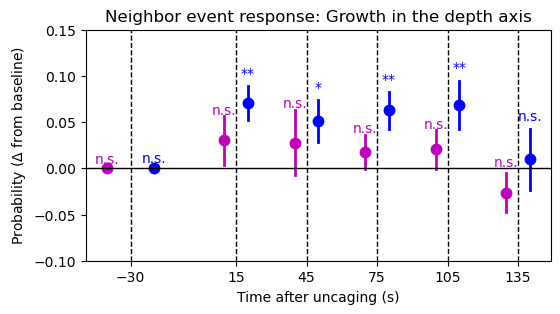

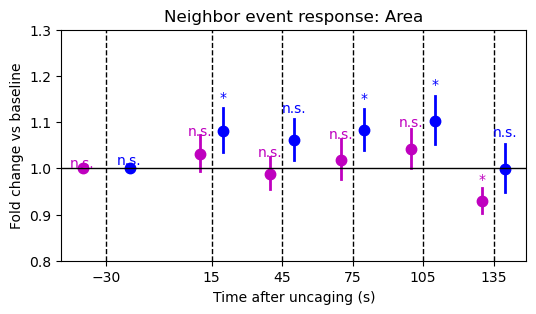

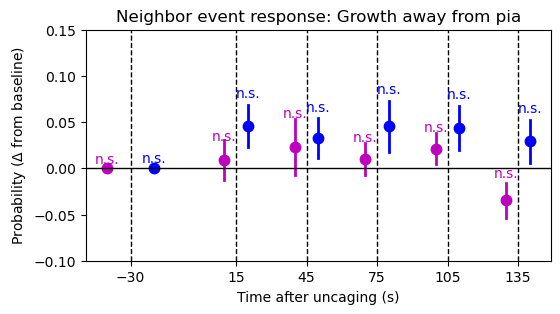

In [12]:
show_as_completed = True

plot_spec = { condition: helper.condition_colors[condition]
              for condition in params['comparison'] }

it = results.items()
if show_as_completed == False:
    it = tqdm( it )

for mark, (label, result) in it:

    result_p_table = result_p_tables[mark]
    
    display_style = params['plots']['mark_display_style'][mark]
    transform = params['plots']['mark_transform'][mark]

    ylim = params['plots']['display_ylim'][display_style]
    ylabel = params['plots']['display_ylabel'][display_style]

    fig, ax = plt.subplots( figsize = (6, 3) )

    population_mark_plot_windowed(
        ax,
        result,
        plot_spec,
        p_table = result_p_table,
        ylim = ylim,
        transform = transform,
        **params['plots']['mark_response_windowed']
    )

    if mark in helper.mark_descriptions:
        ax.set_title( f'Neighbor event response: {helper.mark_descriptions[mark]}' )
    
    ax.set_ylabel( ylabel )
    
    save_figure( params['outputs']['mark_response_windowed'].format(
        prefix = label,
        mark = mark,
    ) )

    if show_as_completed:
        plt.show()
    
    plt.close()

An example $p$-table:

In [13]:
result_p_tables['mark_propGrowAP_bin']

,group,window_start,window_end,p_perm,q_corrected
0,GABA,-60,0,1.000000,1.000000
1,GABA,0,30,0.096903,0.193806
2,GABA,30,60,0.135864,0.219780
3,GABA,60,90,0.352647,0.391830
4,GABA,90,120,0.290709,0.363387
5,GABA,120,150,0.153846,0.219780
6,Glu,-60,0,1.000000,1.000000
7,Glu,0,30,0.001998,0.006660
8,Glu,30,60,0.014985,0.037463
9,Glu,60,90,0.000999,0.004995


#### Save

In [14]:
for mark, result in tqdm( results.items() ):
    
    save_dict = {
        'events_panel': events_panel,
        'params': params,
        'result': result,
        'result_p_table': result_p_tables[mark],
    }

    save_name =  params['outputs']['mark_response_windowed'].format(
        prefix = label,
        mark = mark,
    )
    
    save_data(  save_name, **save_dict )
    save_csv( save_name + '-p_table', result_p_tables[mark] )

100%|██████████| 3/3 [00:00<00:00,  7.34it/s]
